In [9]:
import os
from pathlib import Path

# Get the absolute path to the current file
current_file_path = Path(os.path.abspath("")) / "1"

# Print the current file path
print("Current file path:", current_file_path)

Current file path: /Users/fffgson/Desktop/Coding/word_cloud_service/embeddings/1


In [10]:
from typing import List
from sentence_transformers import SentenceTransformer
import fasttext
import fasttext.util
import numpy as np
import pandas as pd

/Users/fffgson/Desktop/Coding/word_cloud_service/.venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [33]:
models_dict: dict = {
    # "fasttext": fasttext.load_model(
    #     "/Users/fffgson/Desktop/Coding/nuclearhack2024_local/cc.ru.300.bin"
    # ),
    "rubert": SentenceTransformer("cointegrated/rubert-tiny2"),
}
word_list = pd.read_csv(
    "/Users/fffgson/Desktop/Coding/nuclearhack2024_local/words.csv", sep=";"
)["response"].to_numpy()

/Users/fffgson/Desktop/Coding/word_cloud_service/.venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [34]:
class Embedder:
    """
    Получи на вход список слов, прошедших модерацию и лемматизацию.
    Вычисли эмбеддинги слов.
    Вычисли косинусное расстояние между эмбеддингами и получи сходство.
    Вычисли кластеры векторов.
    Верни список из топ кластеров.

    Parameters:
    word_list (List[str]) - изначальный список слов.
    model (str) - какую модель использовать: 'fasttext' или 'rubert'. По умолчанию 'rubert'.

    Returns:
    word_cloud_list (List[str]) - итоговый список из наиболее релевантных слов.
    """

    def __init__(self, model: str = "rubert"):
        assert model.lower().strip() in [
            "rubert",
            "fasttext",
        ], "Assertion error: Model should be FastText or RuBERT"
        self.model_name = model.lower().strip()
        self.model = models_dict[model.lower().strip()]

    def forward(self, word_list: List[str]):
        assert (
            len(word_list) > 0
        ), "Assertion error: Word list should have at least 1 word."
        self.length = len(word_list)
        return (
            self.model.encode(word_list)
            if self.model_name == "rubert"
            else np.array([self.model.get_word_vector(word) for word in word_list])
        )

In [35]:
embedder = Embedder(model="rubert")
embs = embedder.forward(word_list)
embs.shape

(634, 312)

In [8]:
import numpy as np
from sklearn.cluster import KMeans

# Example: Assuming `word_vectors` is a NumPy array of shape (n_words, embedding_dim)
# word_vectors = np.array([...])  # Your word embedding vectors

# Define the number of clusters
n_clusters = 5  # Specify the desired number of clusters

# Initialize KMeans
kmeans = KMeans(n_clusters=5, random_state=42)

# Fit the model
kmeans.fit(embs)

# Get cluster labels
labels = kmeans.labels_

# Optionally, you can also get the cluster centers
cluster_centers = kmeans.cluster_centers_

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


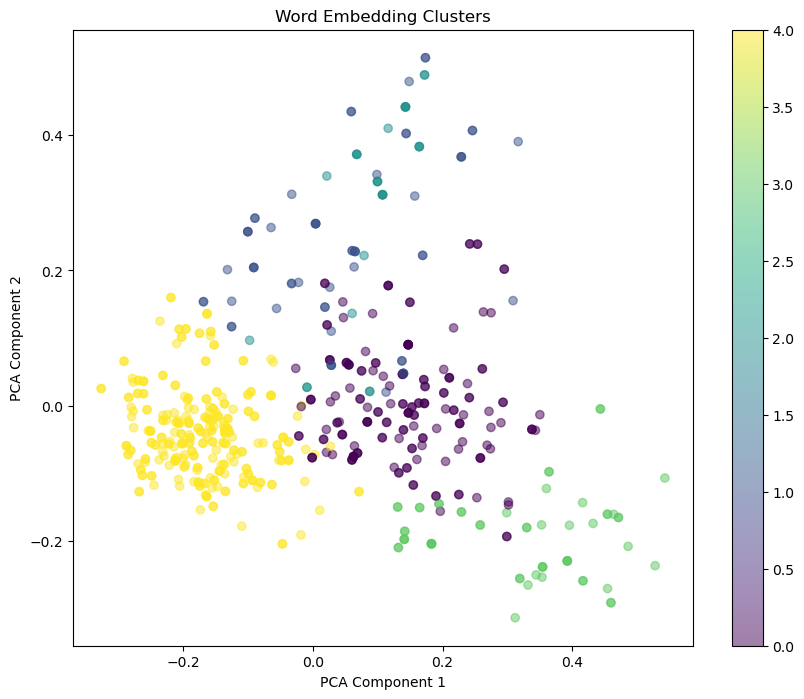

In [51]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(embs)

# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=labels, cmap='viridis', alpha=0.5)
plt.title('Word Embedding Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar()
plt.show()

/Users/fffgson/Desktop/Coding/word_cloud_service/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


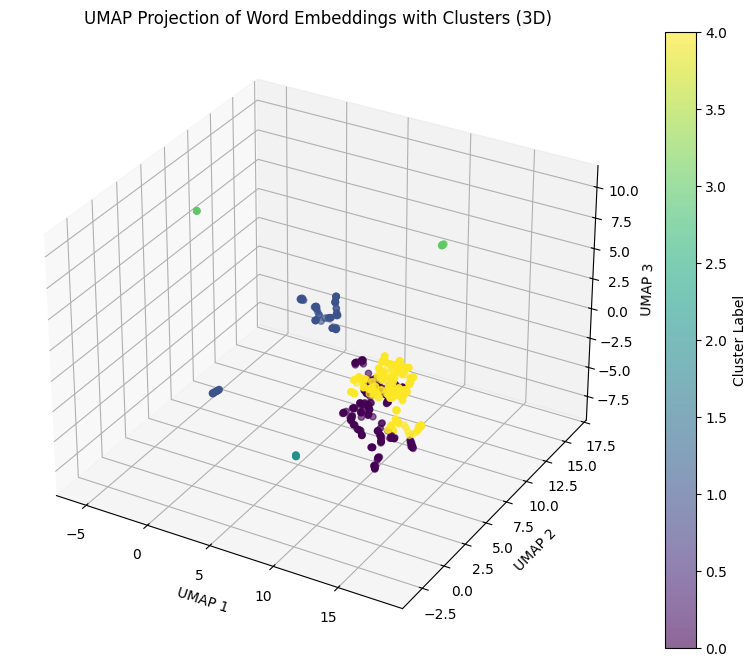

In [36]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

# Sample word embedding vectors (replace this with your actual embeddings)
# For example, let's create random embeddings for demonstration
# Assuming 'embs' is your actual word embeddings
word_embeddings = embs  # Replace 'embs' with your actual embeddings

# Step 1: Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=3, random_state=42)
reduced_embeddings = umap_model.fit_transform(word_embeddings)

# Step 2: Cluster the reduced embeddings using KMeans
num_clusters = 5  # Specify the number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(reduced_embeddings)
labels = kmeans.labels_

# Step 3: Visualize the clusters in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

# Create a scatter plot
scatter = ax.scatter(
    reduced_embeddings[:, 0],
    reduced_embeddings[:, 1],
    reduced_embeddings[:, 2],
    c=labels,
    cmap="viridis",
    alpha=0.6,
)

# Set titles and labels
ax.set_title("UMAP Projection of Word Embeddings with Clusters (3D)")
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_zlabel("UMAP 3")

# Add a color bar
cbar = plt.colorbar(scatter, ax=ax, label="Cluster Label")

# Show the plot
plt.show()

In [44]:
from collections import Counter

# Подсчет количества вхождений в каждый кластер
cluster_counts = Counter(labels)
top_clusters = cluster_counts.most_common(max(1, len(cluster_counts) // 2))

together = np.concatenate(
    (labels.reshape(-1, 1), np.array(word_list).reshape(-1, 1)), axis=1
)

print(cluster_counts)
print(top_clusters)
# # Получение слов из самых больших кластеров
top_words = []
for cluster_id, _ in top_clusters:
    print(cluster_id)
    top_words.extend(together[together[:, 0] == cluster_id][:, 1])

print(np.array(top_words))
print(len(top_words))

Counter({np.int32(4): 281, np.int32(0): 232, np.int32(1): 96, np.int32(3): 16, np.int32(2): 9})
[(np.int32(4), 281), (np.int32(0), 232)]
4
0
['деньги' 'признание' 'свобода' 'интерес' 'удовлетворение' 'стабильность'
 'карьера' 'любовь' 'уважение' 'власть' 'еда' 'рутина' 'комфорт' 'чувство'
 'долг' 'желание' 'мотивация' 'учеба' 'креатив' 'инициатива' 'идея'
 'приключения' 'хобби' 'интерьер' 'стиль' 'награды' 'безопасность'
 'командировки' 'помощь' 'бонусы' 'зарплата' 'благодарность' 'статус'
 'нагрузка' 'интересы' 'проблемы' 'вызовы' 'здоровье' 'жизнь'
 'удовольствие' 'идеалы' 'убеждения' 'ценности' 'праздники' 'свобода'
 'автономность' 'престиж' 'влияние' 'культура' 'дух' 'активность' 'спорт'
 'энергия' 'задания' 'ориентир' 'направление' 'цели' 'путь' 'творчество'
 'дисциплина' 'вдохновение' 'энтузиазм' 'признательность' 'конкуренция'
 'личность' 'уверенность' 'позитив' 'впечатления' 'эмоции' 'проект'
 'обучение' 'предпринимательство' 'ответственность' 'задачи' 'вклад'
 'польза' 'гибкос

Объединяем уменьшенные векторы и лейблы

In [14]:
vec_w_labels = np.concatenate(
    (reduced_embeddings, labels.reshape(-1, 1), np.array(word_list).reshape(-1, 1)),
    axis=1,
)

filtered_rows = vec_w_labels[vec_w_labels[:, 3] == 4]

print(np.unique(vec_w_labels[:, 3]))

['0' '1' '2' '3' '4']


In [18]:
from umap import UMAP


def clusterize(
    embds_list: np.ndarray,
    num_clusters: int = 5,
    num_components: int = 3,
    random_state: int = 42,
):
    umap_model = UMAP(n_components=num_components, random_state=random_state)
    reduced_embds = umap_model.fit_transform(embds_list)
    kmeans_model = KMeans(n_clusters=num_clusters, random_state=random_state)
    kmeans_model.fit(reduced_embds)
    labels = kmeans_model.labels_
    conc_embs = np.concatenate(
        reduced_embds,
        labels.reshape(-1, 1),
        word_list.reshape(-1, 1),
        axis=1,
    )
    unqiue_values = np.unique(conc_embs[:, num_components])


clusterize(embs)

/Users/fffgson/Desktop/Coding/word_cloud_service/.venv/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/Users/fffgson/Desktop/Coding/word_cloud_service/.venv/lib/python3.12/site-packages/umap/umap_.py:2437: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


AttributeError: 'list' object has no attribute 'reshape'

/Users/fffgson/AnacondaFolder/anaconda3/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        50
           1       1.00      1.00      1.00         4
           2       1.00      0.98      0.99        59
           4       1.00      1.00      1.00        14

    accuracy                           0.99       127
   macro avg       1.00      1.00      1.00       127
weighted avg       0.99      0.99      0.99       127

Confusion Matrix:
[[50  0  0  0]
 [ 0  4  0  0]
 [ 1  0 58  0]
 [ 0  0  0 14]]


/Users/fffgson/AnacondaFolder/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


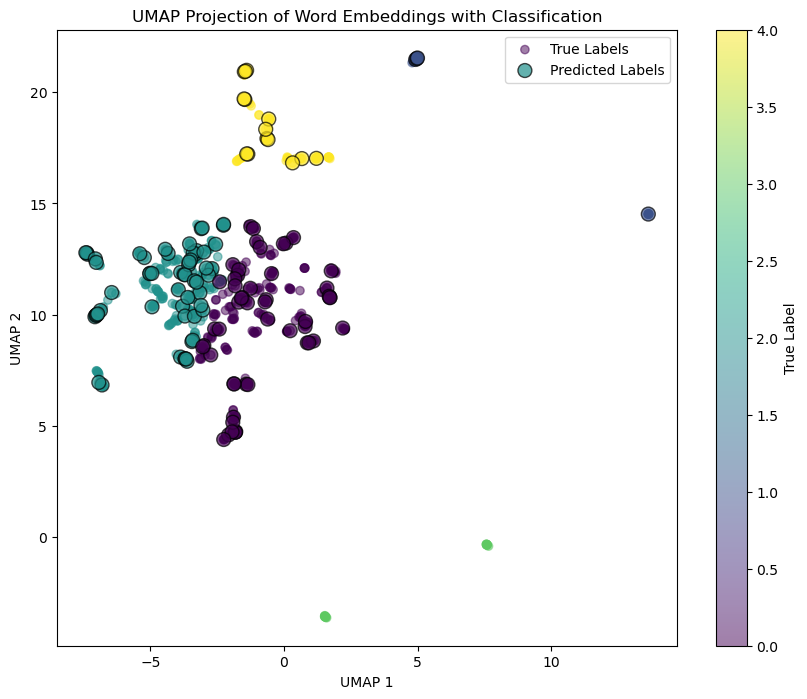

In [67]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Sample word embedding vectors and labels (replace this with your actual embeddings and labels)
# For demonstration, let's create random embeddings and labels
num_classes = 5

# Generate random word embeddings
word_embeddings = embs

# Generate random labels for classification
labels = labels

# Step 1: Reduce dimensions using UMAP
umap_model = umap.UMAP(n_components=2, random_state=42)
reduced_embeddings = umap_model.fit_transform(word_embeddings)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(reduced_embeddings, labels, test_size=0.2, random_state=42)

# Step 3: Train a classifier (Logistic Regression)
classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

# Step 4: Make predictions on the test set
y_pred = classifier.predict(X_test)

# Step 5: Print classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Step 6: Visualize the classification results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.5, label='True Labels')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, edgecolor='k', marker='o', s=100, label='Predicted Labels', alpha=0.7)
plt.title('UMAP Projection of Word Embeddings with Classification')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.colorbar(scatter, label='True Label')
plt.legend()
plt.show()
